In [1]:
import os

os.chdir('/data/zusers/ramirezc/splice-benchmark/spliceai/tissue_specific')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from typing import Dict, Tuple, Set, Optional
from consensus_evaluator import ConsensusSpliceSiteEvaluator

2025-02-27 13:28:17.038983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740680897.057512 3692803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740680897.063124 3692803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 13:28:17.083768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Initialize evaluator
evaluator = ConsensusSpliceSiteEvaluator(
    gencode_gtf="gencode.v29.primary_assembly.annotation_UCSC_names.gtf",
    consensus_fasta="GM12878/GM12878.fasta"
)

In [3]:
# Filter for expressed genes
expressed_transcripts = evaluator.filter_expressed_transcripts(
    quant_tsv="GM12878/ENCFF190NFH.tsv",
    min_tpm=2.0
)

print(list(expressed_transcripts)[:50])


Transcript filtering summary:
Total transcripts: 207507
Expressed transcripts (TPM >= 2.0): 24678
['ENST00000262193.6', 'ENST00000617569.1', 'ENST00000309033.4', 'ENST00000407022.7', 'ENST00000510191.5', 'ENST00000389142.9', 'ENST00000534280.5', 'ENST00000373247.6', 'ENST00000393256.7', 'ENST00000301454.8', 'ENST00000295006.5', 'ENST00000592388.1', 'ENST00000374206.3', 'ENST00000549748.2', 'ENST00000593287.5', 'ENST00000404876.1', 'ENST00000380430.5', 'ENST00000360981.8', 'ENST00000453324.5', 'ENST00000469100.5', 'ENST00000596582.1', 'ENST00000568314.1', 'ENST00000559679.1', 'ENST00000573949.1', 'ENST00000427997.5', 'ENST00000570907.5', 'ENST00000261842.9', 'ENST00000292823.6', 'ENST00000399959.7', 'ENST00000586084.1', 'ENST00000491807.5', 'ENST00000264057.6', 'ENST00000560458.5', 'ENST00000551805.1', 'ENST00000528545.1', 'ENST00000524931.1', 'ENST00000355552.7', 'ENST00000611969.4', 'ENST00000560318.1', 'ENST00000299601.9', 'ENST00000520751.1', 'ENST00000416769.2', 'ENST00000559931.5

In [4]:
# Load or generate and save ground truth
ground_truth_acceptor, ground_truth_donor = evaluator.get_ground_truth(
    expressed_transcripts=expressed_transcripts
)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'exon_number', 'exon_id', 'level', 'transcript_support_level', 'tag', 'havana_gene', 'havana_transcript', 'ont', 'protein_id', 'ccdsid']


In [5]:
# # Generate predictions with serialization
# pred_acceptor, pred_donor = evaluator.generate_spliceai_predictions(
#     predictions_file="GM12878/predictions.pkl"
# )

In [6]:
pred_acceptor, pred_donor = evaluator.load_serialized_data('GM12878/predictions.pkl')

In [7]:
# Add this code to check predictions
print("\nPrediction verification:")
for chrom in evaluator.target_chromosomes:
    nonzero_count = np.count_nonzero(pred_acceptor[chrom])
    high_value_count = np.sum(pred_acceptor[chrom] >= 0.9)
    print(f"Chromosome {chrom}: {nonzero_count} non-zero predictions, {high_value_count} values ≥ 0.9")
    if nonzero_count > 0:
        # Check distribution of values
        values, counts = np.unique(pred_acceptor[chrom][pred_acceptor[chrom] > 0], return_counts=True)
        print(f"Value distribution: {list(zip(values[:5], counts[:5]))}")


Prediction verification:
Chromosome chr1: 26902294 non-zero predictions, 8252 values ≥ 0.9
Value distribution: [(1.2950841571032767e-12, 1), (1.930169565844686e-12, 1), (2.2179699483287907e-12, 1), (2.473478886988456e-12, 1), (2.802970095611146e-12, 1)]
Chromosome chr3: 15355286 non-zero predictions, 4404 values ≥ 0.9
Value distribution: [(2.7428688660624534e-12, 1), (2.958377900291742e-12, 1), (3.171671909482643e-12, 1), (3.190032873273685e-12, 1), (3.2347787642938997e-12, 1)]
Chromosome chr5: 13133419 non-zero predictions, 3565 values ≥ 0.9
Value distribution: [(2.5624376752408917e-12, 1), (3.0842294863886455e-12, 1), (4.186151425500384e-12, 1), (4.304632605228731e-12, 1), (4.402924205781922e-12, 1)]
Chromosome chr7: 13092131 non-zero predictions, 3539 values ≥ 0.9
Value distribution: [(2.9880347328370416e-12, 1), (3.453927031535353e-12, 1), (3.662643105473151e-12, 1), (4.0357795230705484e-12, 1), (4.20637569914506e-12, 1)]
Chromosome chr9: 10528053 non-zero predictions, 3169 values

In [8]:
# Calculate metrics
acceptor_precision, acceptor_recall, acceptor_auprc, acceptor_top_k = evaluator.calculate_metrics(
    ground_truth_acceptor, 
    pred_acceptor
)
donor_precision, donor_recall, donor_auprc, donor_top_k = evaluator.calculate_metrics(
    ground_truth_donor,
    pred_donor
)

Calculating AUPRC using non-zero prediction regions...
Chromosome chr1: 26902294 positions evaluated
Chromosome chr3: 15355286 positions evaluated
Chromosome chr5: 13133419 positions evaluated
Chromosome chr7: 13092131 positions evaluated
Chromosome chr9: 10528053 positions evaluated
Calculating AUPRC using non-zero prediction regions...
Chromosome chr1: 26902294 positions evaluated
Chromosome chr3: 15355286 positions evaluated
Chromosome chr5: 13133419 positions evaluated
Chromosome chr7: 13092131 positions evaluated
Chromosome chr9: 10528053 positions evaluated


/tmp/ipykernel_3692803/780320661.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("GM12878/auprc_topk_spliceai.png", dpi=300)


Acceptor AUPRC: 0.9546, Top-k: 0.9083
Donor AUPRC: 0.9532, Top-k: 0.9046
Mean AUPRC: 0.9539, Mean Top-k: 0.9065


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


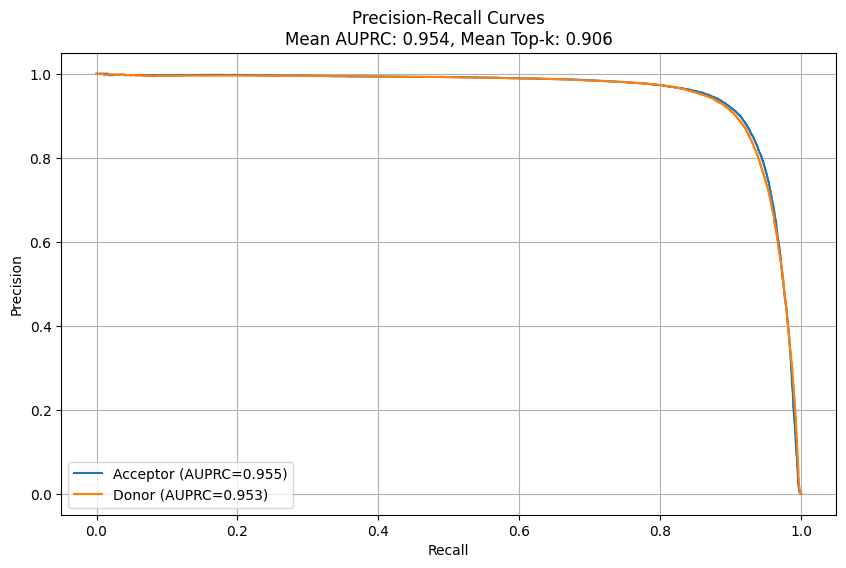

In [9]:
# Calculate mean metrics
mean_auprc = (acceptor_auprc + donor_auprc) / 2
mean_top_k = (acceptor_top_k + donor_top_k) / 2

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(acceptor_recall, acceptor_precision, label=f'Acceptor (AUPRC={acceptor_auprc:.3f})')
plt.plot(donor_recall, donor_precision, label=f'Donor (AUPRC={donor_auprc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves\nMean AUPRC: {mean_auprc:.3f}, Mean Top-k: {mean_top_k:.3f}')
plt.legend()
plt.grid(True)
plt.savefig("GM12878/auprc_topk_spliceai.png", dpi=300)

# Print results
print(f"Acceptor AUPRC: {acceptor_auprc:.4f}, Top-k: {acceptor_top_k:.4f}")
print(f"Donor AUPRC: {donor_auprc:.4f}, Top-k: {donor_top_k:.4f}")
print(f"Mean AUPRC: {mean_auprc:.4f}, Mean Top-k: {mean_top_k:.4f}")

In [10]:
# Get the indices for the region of interest 
gene_gt = ground_truth_acceptor['chr1'][944203:958458]
gene_pred = pred_acceptor['chr1'][944203:958458]

# Get absolute indices where values are positive
gt_positive_indices = {idx + 944203 for idx in np.where(gene_gt == 1)[0]}
pred_positive_indices = {idx + 944203 for idx in np.where(gene_pred >= 0.9)[0]}

# Write to file
with open('GM12878/acceptor_splice_indices.txt', 'w') as f:
    f.write("Ground_Truth_Position\tPrediction_Position\n")  # Header
    
    # Write all positions, marking matches
    all_positions = sorted(gt_positive_indices | pred_positive_indices)
    for pos in all_positions:
        gt_mark = str(pos) if pos in gt_positive_indices else "-"
        pred_mark = str(pos) if pos in pred_positive_indices else "-"
        f.write(f"{gt_mark}\t{pred_mark}\n")

# Print summary statistics
print(f"Number of ground truth splice sites: {len(gt_positive_indices)}")
print(f"Number of predicted splice sites: {len(pred_positive_indices)}")
print(f"Number of matching positions: {len(gt_positive_indices & pred_positive_indices)}")

Number of ground truth splice sites: 18
Number of predicted splice sites: 16
Number of matching positions: 16


In [11]:
# Get the indices for the region of interest 
gene_gt = ground_truth_donor['chr1'][944203:958458]
gene_pred = pred_donor['chr1'][944203:958458]

# Get absolute indices where values are positive
gt_positive_indices = {idx + 944203 for idx in np.where(gene_gt == 1)[0]}
pred_positive_indices = {idx + 944203 for idx in np.where(gene_pred >= 0.9)[0]}

# Write to file
with open('GM12878/donor_splice_indices.txt', 'w') as f:
    f.write("Ground_Truth_Position\tPrediction_Position\n")  # Header
    
    # Write all positions, marking matches
    all_positions = sorted(gt_positive_indices | pred_positive_indices)
    for pos in all_positions:
        gt_mark = str(pos) if pos in gt_positive_indices else "-"
        pred_mark = str(pos) if pos in pred_positive_indices else "-"
        f.write(f"{gt_mark}\t{pred_mark}\n")

# Print summary statistics
print(f"Number of ground truth splice sites: {len(gt_positive_indices)}")
print(f"Number of predicted splice sites: {len(pred_positive_indices)}")
print(f"Number of matching positions: {len(gt_positive_indices & pred_positive_indices)}")

Number of ground truth splice sites: 17
Number of predicted splice sites: 17
Number of matching positions: 17
